In [1]:
from imutils import paths
import argparse
import cv2
import os
import pandas as pd
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# The dataset is taken from: "https://www.kaggle.com/kwentar/usage-example-of-blur-dataset"
BLUR_DATASET = r"..\images"
# TODO: We want the threshold value to be set according to the filter level requestedץ
BLURRY_TRESHOLD = 50.0
NUMBER_OF_IMAGES_TO_TEST = 10

In [3]:
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [4]:
FILTER_FUNC = variance_of_laplacian

In [5]:
def filter_image(image_path):
    """
    Gets a path of an image and outputs the blurry value of the given image.
    :param image_path: the path of an input image.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = FILTER_FUNC(gray)

    if fm > BLURRY_TRESHOLD:
        print(image_path + " - Not Blurry: " + str(fm))

    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < BLURRY_TRESHOLD:
        print(image_path + " - Blurry: " + str(fm))

    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()

..\images\2015_02464.jpg - Not Blurry: 373.3007054428034


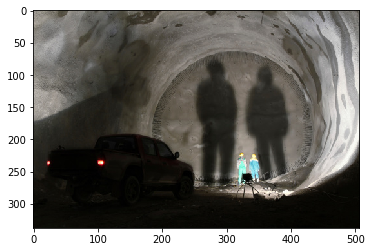

..\images\170_IPHONE-8_S.JPG - Not Blurry: 475.83700463220134


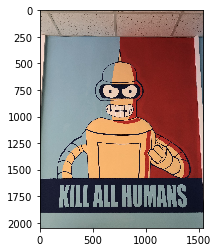

..\images\2015_06674.JPEG - Not Blurry: 221.8648233955556


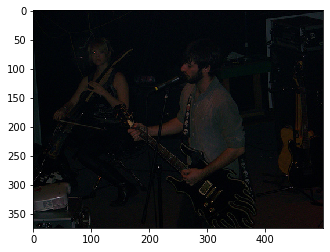

..\images\139_NIKON-D3400-18-55MM_F.JPG - Blurry: 10.755679440153699


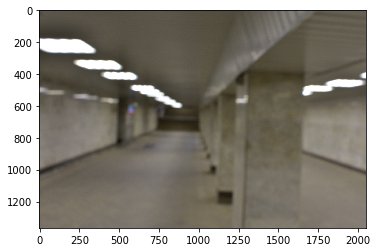

..\images\314_IPHONE-5S_F.jpeg - Blurry: 11.765808215265281


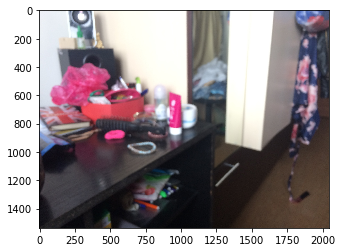

..\images\2015_02834.jpg - Not Blurry: 102.24842436446993


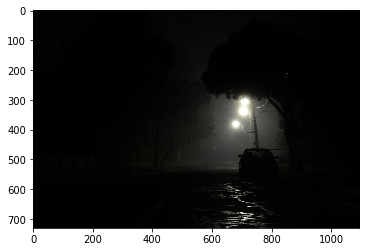

..\images\2015_02462.jpg - Blurry: 42.549825568145295


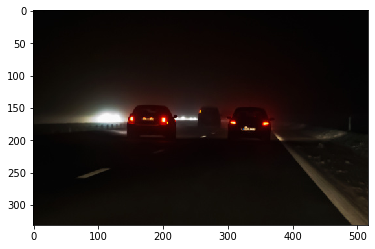

..\images\326_XIAOMI-PROCOFONE-F1_S.jpg - Not Blurry: 490.58275119024074


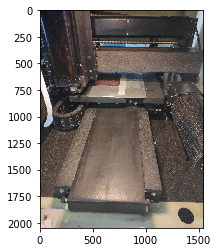

..\images\0_IPHONE-SE_M.JPG - Blurry: 48.266838708200034


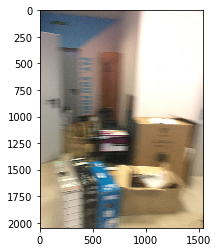

..\images\2015_06277.jpg - Not Blurry: 384.2254675329906


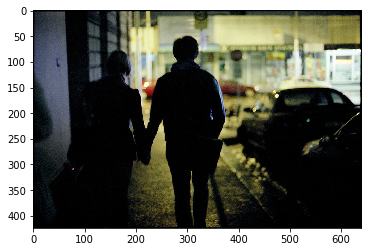

In [6]:
if __name__ == '__main__':
    image_paths = list(paths.list_images(BLUR_DATASET))
    shuffle(image_paths)

    # loop over the input images
    for image_ath in image_paths[:NUMBER_OF_IMAGES_TO_TEST]:
        filter_image(image_ath)

In [7]:
IMAGE_DATASET = r"..\classification_dataset"
def get_data(path):
    images=[]
    for _, _, files in os.walk(path):
        for filename in files:
            image_grayscale = cv2.imread(path+"\\"+filename, 0)
            images.append(image_grayscale)
    return images

good_images = get_data(IMAGE_DATASET+ "\\positive")
blurry_images = get_data(IMAGE_DATASET+ "\\weak_negative")
bad_images = get_data(IMAGE_DATASET+"\\strong_negative")

In [9]:
from skimage.color import rgb2gray
from skimage.filters import laplace, sobel, roberts

def extract_features(image):
    #laplacian - good measure for noise in a section of the image
    lap_feat = laplace(image)
    #sobel - edge detection
    sob_feat = sobel(image)
    #roberts - different edge detection
    rob_feat = roberts(image)
    features = [lap_feat.mean(),lap_feat.var(),np.amax(lap_feat),
                        sob_feat.mean(),sob_feat.var(),np.max(sob_feat),
                        rob_feat.mean(),rob_feat.var(),np.max(rob_feat)]
        
    return features

def create_df(images):
    features = [extract_features(image) for image in images]
    return pd.DataFrame(features)

good_images_df = create_df(good_images)
blurry_images_df = create_df(blurry_images)
bad_images_df = create_df(bad_images)

In [50]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report

def train_and_eval(dataset, labels, model):
    x_train,x_valid,y_train,y_valid = train_test_split(dataset,labels,test_size=0.2,stratify=labels)
    model.fit(x_train,y_train)
    pred =model.predict(x_valid)
    print('Accuracy:',accuracy_score(y_valid,pred))
    print('Confusion matrix:\n',confusion_matrix(y_valid,pred))
    print('F1_score:',f1_score(y_valid,pred))
    print('Classification_report:\n',classification_report(y_valid,pred))
    

dataset = pd.concat([good_images_df, blurry_images_df, bad_images_df], axis=0)
labels = np.concatenate((np.ones((good_images_df.shape[0], )), 
                         np.ones((blurry_images_df.shape[0], ))*0 , # binarized to bad and good
                         np.zeros((bad_images_df.shape[0], ))), axis=0)
model_checked = svm.SVC(C=100,kernel='rbf')
model_checked = LogisticRegression(penalty="l1", solver='liblinear', C=100)

train_and_eval(dataset, labels, model_checked)

Accuracy: 0.8165680473372781
Confusion matrix:
 [[60 16]
 [15 78]]
F1_score: 0.8342245989304814
Classification_report:
               precision    recall  f1-score   support

         0.0       0.80      0.79      0.79        76
         1.0       0.83      0.84      0.83        93

    accuracy                           0.82       169
   macro avg       0.81      0.81      0.81       169
weighted avg       0.82      0.82      0.82       169



In [ ]:
# TODO: 
# false positive is less bad (display junk photo>discard good one, around twice as important)
# regression problem / multiclass - blurry is not quite as bad as bad images
# more data, especially bad images
# better models/param search/CV/...